<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Dayana Navarro Valencia y Juan Pablo Ruiz Magaña

**Fecha:** 7 de mayo del 2021

**Expediente** : if721470
**Profesor:** Oscar David Jaramillo Zuluaga.

## Link de Github: https://github.com/DayanaNavarro/Tarea-11

# Tarea 11: Clase 24

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

# RESPUESTA DAYANA

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# ACTIVO MC´DONALS

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['MCD'], '2017-01-01')
closes_mc = closes.loc[:,'MCD']
closes_mc.head()

Date
2017-01-03    107.688629
2017-01-04    107.562599
2017-01-05    107.760643
2017-01-06    108.714912
2017-01-09    108.417847
Name: MCD, dtype: float64

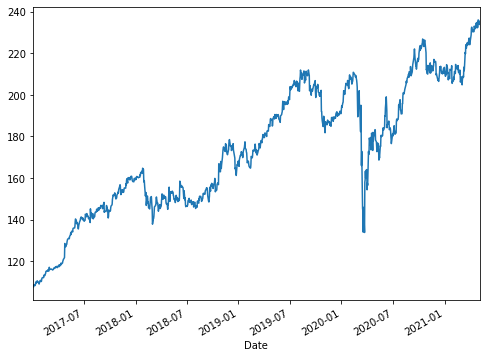

In [5]:
closes_mc.plot(figsize=(8,6));

In [6]:
closes_mc[-1]

235.0399932861328

## Calculamos rendimientos

In [7]:
ret_mc = calc_daily_ret(closes_mc)

## Descargamos datos de opciones para poder valuarlos

In [8]:
pd.set_option('display.max_rows', 10)

mc = web.YahooOptions('MCD')
mc_opt = mc.get_all_data().reset_index()
mc_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,,,,,,,,,,,,
2021-05-07,217.5,call,MCD210507C00217500,17.80,16.25,18.90,0.00,0.000000,5.0,8.0,0.834963,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:18:23,"{'contractSymbol': 'MCD210507C00217500', 'stri..."
2021-05-07,230.0,call,MCD210507C00230000,4.58,4.85,5.60,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."
2021-05-07,230.0,put,MCD210507P00230000,0.23,0.21,0.27,-0.25,-52.083332,278.0,921.0,0.207527,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:34:19,"{'contractSymbol': 'MCD210507P00230000', 'stri..."
2021-05-07,232.5,call,MCD210507C00232500,3.09,2.79,3.10,0.91,41.743110,476.0,555.0,0.177498,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:22:49,"{'contractSymbol': 'MCD210507C00232500', 'stri..."
2021-05-07,232.5,put,MCD210507P00232500,0.55,0.45,0.54,-0.43,-43.877552,280.0,394.0,0.174325,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:27:40,"{'contractSymbol': 'MCD210507P00232500', 'stri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20,145.0,call,MCD230120C00145000,80.80,86.15,89.40,0.00,0.000000,1.0,4.0,0.000010,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-03-17 18:46:10,"{'contractSymbol': 'MCD230120C00145000', 'stri..."
2023-01-20,145.0,put,MCD230120P00145000,3.73,2.92,4.15,0.00,0.000000,4.0,133.0,0.308265,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-29 14:29:48,"{'contractSymbol': 'MCD230120P00145000', 'stri..."
2023-01-20,150.0,call,MCD230120C00150000,85.18,82.50,87.50,0.00,0.000000,1.0,41.0,0.251625,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:19:31,"{'contractSymbol': 'MCD230120C00150000', 'stri..."


## Volatility smile 

In [44]:
fecha = '2021-05-15'
call_f1 = mc_opt.loc[(mc_opt.Expiry== fecha1) & (mc_opt.Type=='call')]


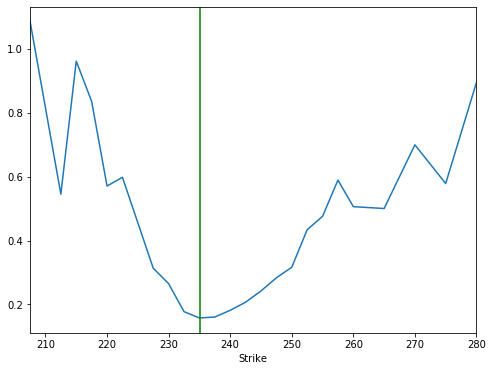

In [38]:
# Para los call de la fecha 1
ax = call_f1.set_index('Strike').loc[:, 'IV'].plot(figsize=(8,6))
ax.axvline(call_f1.Underlying_Price.iloc[0], color='g');

In [46]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='call') & (mc_opt.Strike==230) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
369,230.0,2021-05-07,call,MCD210507C00230000,4.58,4.85,5.6,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."


In [47]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            230
Expiry                                            2021-05-07 00:00:00
Type                                                             call
Symbol                                             MCD210507C00230000
Last                                                             4.58
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 17:16:51
JSON                {'contractSymbol': 'MCD210507C00230000', 'stri...
Name: 369, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [48]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [49]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

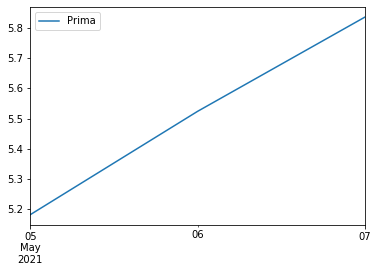

In [50]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [51]:
call.iloc[-1]

Prima    5.835541
Name: 2021-05-07 00:00:00, dtype: float64

### Intervarlos de confianza

In [52]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.714381104075803, 5.956701529726632)


In [53]:
opt_valuar['JSON']

{'contractSymbol': 'MCD210507C00230000',
 'strike': 230.0,
 'currency': 'USD',
 'lastPrice': 4.58,
 'change': 0.11000013,
 'percentChange': 2.460853,
 'volume': 50,
 'openInterest': 445,
 'bid': 4.85,
 'ask': 5.6,
 'contractSize': 'REGULAR',
 'expiration': 1620345600,
 'lastTradeDate': 1620235011,
 'impliedVolatility': 0.2651440673828125,
 'inTheMoney': True}

### 1.2 Histograma de rendimientos

In [57]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)


In [58]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

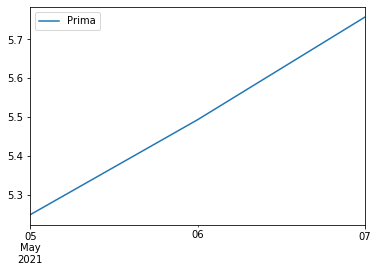

In [59]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [60]:
call_hist.iloc[-1]

Prima    5.757603
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [61]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.634705479118243, 5.880499746676507)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [62]:
opt_valuar['JSON']['lastPrice']

4.58

# 'CALL'- down-and-out

## VALUACIÓN DE UNA OPCION 'CALL'- down-and-out

### 3.1 Modelo normal de rendimientos

In [64]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = 0.006/360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666667e-05)

In [65]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [66]:
opt_valuar.Underlying_Price

235.04

In [84]:
pd.set_option('display.max_columns', 35)

B= 230

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)> 0
I


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-06,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-07,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,False


In [85]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(230.0, 235.04)

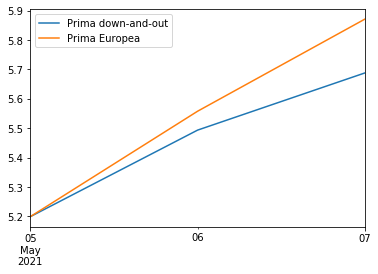

In [86]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [87]:
call.iloc[-1]

Prima Europea    5.871478
Name: 2021-05-07 00:00:00, dtype: float64

In [88]:
callui.iloc[-1]

Prima down-and-out    5.688329
Name: 2021-05-07 00:00:00, dtype: float64

#  'PUT'- Up-and-out

## VALUACIÓN DE UNA OPCION 'PUT'- Up-and-out

In [147]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='put') & (mc_opt.Strike==240) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
429,240.0,2021-05-07,put,MCD210507P00240000,8.0,4.6,6.35,1.75,28.0,1.0,23.0,0.383307,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 14:42:42,"{'contractSymbol': 'MCD210507P00240000', 'stri..."


In [148]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            240
Expiry                                            2021-05-07 00:00:00
Type                                                              put
Symbol                                             MCD210507P00240000
Last                                                                8
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 14:42:42
JSON                {'contractSymbol': 'MCD210507P00240000', 'stri...
Name: 429, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [149]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [150]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

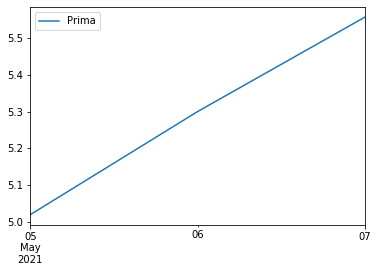

In [151]:
strike = K
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

In [152]:
put.iloc[-1]

Prima    5.557368
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [153]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.43611620463181, 5.678620540401981)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [154]:
opt_valuar['JSON']['lastPrice']

8.0

### 1.2 Histograma de rendimientos

In [155]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)



In [156]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

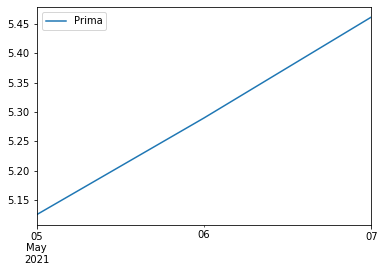

In [157]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [158]:
put_hist.iloc[-1]

Prima    5.461964
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [159]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.340990593340168, 5.5829379727935695)


In [160]:
opt_valuar['JSON']['lastPrice']

8.0

In [161]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [162]:
opt_valuar.Underlying_Price

235.04

In [163]:
pd.set_option('display.max_columns', 35)

B= 240

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0) > 0
I

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True
2021-05-06,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,False,True,False,True,True,True,True,True,True,True,False,False,True,False,True,True,True
2021-05-07,True,False,True,False,True,True,True,True,False,True,True,False,True,True,True,True,True,...,False,True,False,True,True,True,False,True,True,True,False,False,True,False,True,True,True


In [164]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(240.0, 235.04)

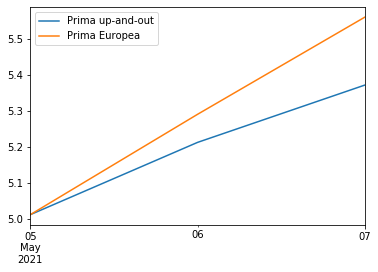

In [165]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes , 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [166]:
put.iloc[-1]

Prima Europea    5.561215
Name: 2021-05-07 00:00:00, dtype: float64

In [167]:
putui.iloc[-1]

Prima up-and-out    5.372725
Name: 2021-05-07 00:00:00, dtype: float64

## ANALISIS FINAL

# RESPUESTA JUAN PABLO

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

## Se descargan los precios del subyacente: `MSFT`

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['MSFT'],'2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     58.538
2017-01-04     58.276
2017-01-05     58.276
2017-01-06     58.782
2017-01-09     58.595
               ...   
2021-04-30    252.180
2021-05-03    251.860
2021-05-04    247.790
2021-05-05    246.470
2021-05-06    249.730
Name: MSFT, Length: 1093, dtype: float64

## Graficar los precios

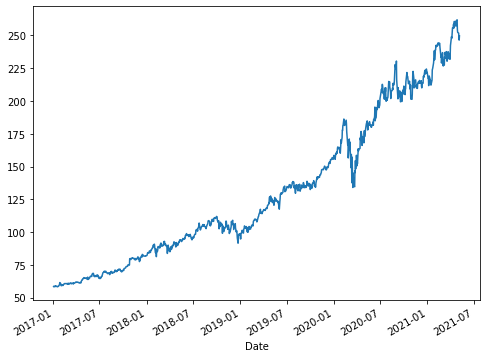

In [5]:
closes_msft.plot(figsize=[8,6]);

## Calcular los rendimientos

In [6]:
ret_msft = calc_daily_ret(closes_msft)

## Descargar datos de opciones para poder valuarlos

_Opciones de MSFT_

In [7]:
pd.set_option('display.max_rows',10)

msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-05-07,200.0,call,MSFT210507C00200000,...,2021-05-06 20:00:02,2021-05-05 19:00:24,"{'contractSymbol': 'MSFT210507C00200000', 'str..."
2021-05-07,155.0,put,MSFT210507P00155000,...,2021-05-06 20:00:02,2021-04-23 17:46:50,"{'contractSymbol': 'MSFT210507P00155000', 'str..."
2021-05-07,120.0,put,MSFT210507P00120000,...,2021-05-06 20:00:02,2021-05-03 13:30:01,"{'contractSymbol': 'MSFT210507P00120000', 'str..."
2021-05-07,120.0,call,MSFT210507C00120000,...,2021-05-06 20:00:02,2021-05-06 19:59:12,"{'contractSymbol': 'MSFT210507C00120000', 'str..."
2021-05-07,252.5,put,MSFT210507P00252500,...,2021-05-06 20:00:02,2021-05-06 19:58:56,"{'contractSymbol': 'MSFT210507P00252500', 'str..."
...,...,...,...,...,...,...,...
2023-06-16,285.0,call,MSFT230616C00285000,...,2021-05-06 20:00:02,2021-05-06 13:52:47,"{'contractSymbol': 'MSFT230616C00285000', 'str..."
2023-06-16,285.0,put,MSFT230616P00285000,...,2021-05-06 20:00:02,2021-04-29 19:07:08,"{'contractSymbol': 'MSFT230616P00285000', 'str..."
2023-06-16,290.0,call,MSFT230616C00290000,...,2021-05-06 20:00:02,2021-05-06 16:45:37,"{'contractSymbol': 'MSFT230616C00290000', 'str..."


>Elijo una fecha de vencimiento en particular.

In [8]:
fecha = '2021-06-18'
opt_call = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Expiry==fecha)]
opt_call

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
0,65.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-04-30 14:37:48,"{'contractSymbol': 'MSFT210618C00065000', 'str..."
2,70.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-04-30 13:49:44,"{'contractSymbol': 'MSFT210618C00070000', 'str..."
6,75.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-04 17:43:47,"{'contractSymbol': 'MSFT210618C00075000', 'str..."
10,80.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-03-29 14:22:01,"{'contractSymbol': 'MSFT210618C00080000', 'str..."
20,85.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-04-20 13:47:45,"{'contractSymbol': 'MSFT210618C00085000', 'str..."
...,...,...,...,...,...,...,...
1769,360.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-05 19:07:34,"{'contractSymbol': 'MSFT210618C00360000', 'str..."
1792,365.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-06 15:21:59,"{'contractSymbol': 'MSFT210618C00365000', 'str..."
1808,370.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-06 16:53:46,"{'contractSymbol': 'MSFT210618C00370000', 'str..."
1827,375.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-06 13:36:22,"{'contractSymbol': 'MSFT210618C00375000', 'str..."


## Sonrisa de volatilidad

>Utilizo la sonrisa de volatilidad para elegir mi precio de ejercicio 

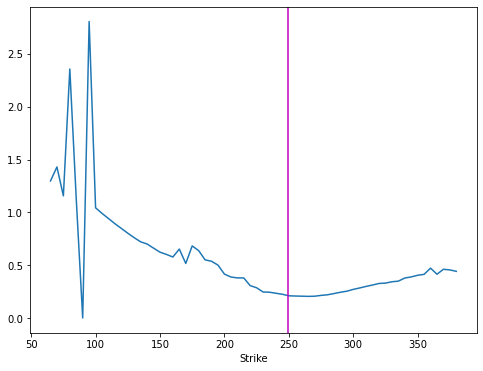

In [9]:
smile = opt_call.set_index('Strike').loc[:,'IV'].plot(figsize=[8,6])
smile.axvline(opt_call.Underlying_Price.iloc[0],color='m')

In [10]:
# valor actual del subyacente
print('El precio actual del activo es',opt_call.Underlying_Price.iloc[0])

El precio actual del activo es 249.73


In [11]:
# strike elegido
K = 255

In [12]:
opt_select = opt_call.loc[ (opt_call.Expiry==fecha) & (opt_call.Strike==K)]
opt_select

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1082,255.0,2021-06-18,call,...,2021-05-06 20:00:02,2021-05-06 19:59:12,"{'contractSymbol': 'MSFT210618C00255000', 'str..."


In [13]:
i_opt = opt_select.index
opcion = msft_opt.loc[i_opt[0]]
opcion['JSON']

{'contractSymbol': 'MSFT210618C00255000',
 'strike': 255.0,
 'currency': 'USD',
 'lastPrice': 4.75,
 'change': 1.25,
 'percentChange': 35.714287,
 'volume': 1979,
 'openInterest': 10049,
 'bid': 4.6,
 'ask': 4.85,
 'contractSize': 'REGULAR',
 'expiration': 1623974400,
 'lastTradeDate': 1620331152,
 'impliedVolatility': 0.20777159423828123,
 'inTheMoney': False}

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

## Modelo normal de rendimientos

Tomo la tasa libre de riesgo de la pagina de la FED

 https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

In [14]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = (0.06/100)/360
mu,sigma,r

(0.001328477164498612, 0.017979041435552272, 1.6666666666666665e-06)

## Simulación de precios

In [15]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

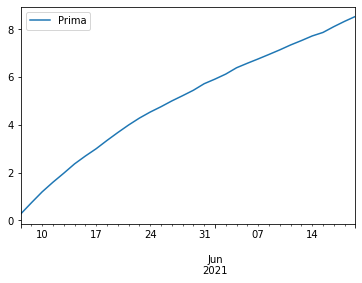

In [16]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [17]:
call.iloc[-1]

Prima    8.52
Name: 2021-06-18 00:00:00, dtype: float64

## Intervalos de confianza

In [18]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(8.018984151950425, 9.02017810451465)


## Histograma de rendimientos

In [19]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [20]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

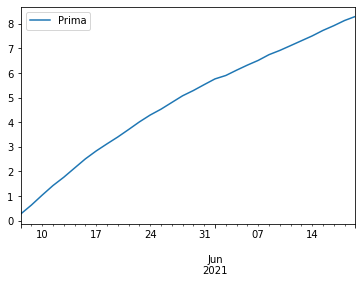

In [21]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [22]:
call_hist.iloc[-1]

Prima    8.298
Name: 2021-06-18 00:00:00, dtype: float64

## Intervalos de confianza

In [23]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(7.796978864660969, 8.798512636210337)


In [24]:
opcion['JSON']['lastPrice']

4.75

## Valuación de una opción call down and out

>Como es un down la barrera debe estar abajo del spot price


In [25]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 240

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-06,True,True,False,True,True,True,True,...,True,True,True,True,False,True,True
2021-05-07,True,True,False,True,True,True,True,...,False,True,True,True,False,True,True
2021-05-10,True,True,False,True,True,True,True,...,False,True,True,True,False,True,True
2021-05-11,True,True,False,True,True,True,True,...,False,True,True,True,False,True,True
2021-05-12,True,True,False,False,True,True,True,...,False,True,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,True,False,False,False,True,True,True,...,False,False,True,True,False,True,False
2021-06-15,True,False,False,False,True,True,True,...,False,False,True,False,False,True,False
2021-06-16,True,False,False,False,True,True,True,...,False,False,True,False,False,True,False
2021-06-17,True,False,False,False,True,True,True,...,False,False,True,False,False,True,False


## Valuación con rendimientos normales

In [26]:
K = opcion.Strike
S0 = opcion.Underlying_Price
K,S0

(255.0, 249.73)

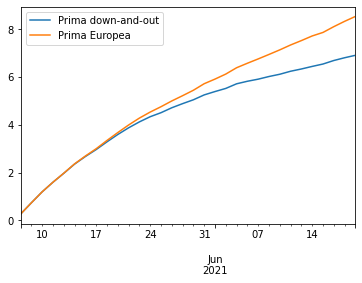

In [27]:
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [28]:
call.iloc[-1]

Prima Europea    8.52
Name: 2021-06-18 00:00:00, dtype: float64

In [29]:
callui.iloc[-1]

Prima down-and-out    6.897
Name: 2021-06-18 00:00:00, dtype: float64

## Valuación con el método del histograma

In [30]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [31]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [32]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 240

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes_hist > B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-06,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-11,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-12,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,False,False,True,False,True,False,True,...,True,True,True,False,True,True,False
2021-06-15,False,False,True,False,True,False,True,...,True,True,True,False,True,True,False
2021-06-16,False,False,True,False,True,False,True,...,True,True,True,False,True,False,False
2021-06-17,False,False,True,False,True,False,True,...,True,True,True,False,True,False,False


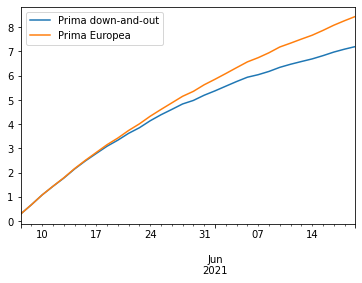

In [33]:
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes_hist-strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [34]:
callui.iloc[-1]

Prima down-and-out    7.202
Name: 2021-06-18 00:00:00, dtype: float64

In [35]:
call.iloc[-1]

Prima Europea    8.445
Name: 2021-06-18 00:00:00, dtype: float64

## Valuación de una put como una Europea

In [36]:
opt_put = msft_opt.loc[(msft_opt.Type=='put') & (msft_opt.Expiry==fecha)]
opt_put


,Strike,Expiry,Type,Symbol,Last,Bid,Ask,...,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
1,65.0,2021-06-18,put,MSFT210618P00065000,0.01,0.00,0.01,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-30 16:16:58,"{'contractSymbol': 'MSFT210618P00065000', 'str..."
3,70.0,2021-06-18,put,MSFT210618P00070000,0.01,0.00,0.01,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-23 16:08:57,"{'contractSymbol': 'MSFT210618P00070000', 'str..."
7,75.0,2021-06-18,put,MSFT210618P00075000,0.04,0.00,0.03,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-28 19:15:33,"{'contractSymbol': 'MSFT210618P00075000', 'str..."
11,80.0,2021-06-18,put,MSFT210618P00080000,0.02,0.00,0.02,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-05-04 18:05:57,"{'contractSymbol': 'MSFT210618P00080000', 'str..."
21,85.0,2021-06-18,put,MSFT210618P00085000,0.04,0.00,0.05,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-09 16:02:14,"{'contractSymbol': 'MSFT210618P00085000', 'str..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,335.0,2021-06-18,put,MSFT210618P00335000,81.15,84.70,87.65,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-28 18:12:15,"{'contractSymbol': 'MSFT210618P00335000', 'str..."
1681,340.0,2021-06-18,put,MSFT210618P00340000,87.90,89.65,92.65,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-09 13:41:03,"{'contractSymbol': 'MSFT210618P00340000', 'str..."
1706,345.0,2021-06-18,put,MSFT210618P00345000,91.05,94.55,96.90,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-28 17:36:42,"{'contractSymbol': 'MSFT210618P00345000', 'str..."
1728,350.0,2021-06-18,put,MSFT210618P00350000,96.19,98.85,102.65,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-04-28 18:04:16,"{'contractSymbol': 'MSFT210618P00350000', 'str..."


## Sonrisa de volatilidad

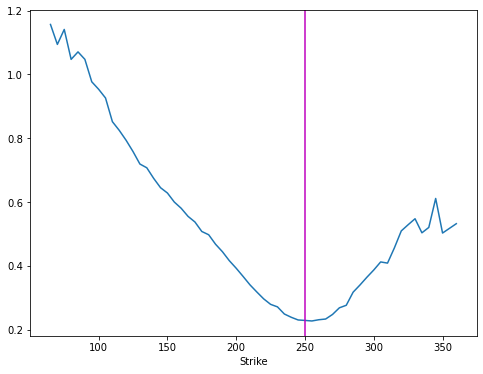

In [37]:
smile = opt_put.set_index('Strike').loc[:,'IV'].plot(figsize=[8,6])
smile.axvline(opt_put.Underlying_Price.iloc[0],color='m')

In [38]:
#strike elegido
K = 230

In [39]:
opt = opt_put.loc[(opt_put.Strike==K) & (opt_put.Expiry==fecha)]
opt

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,...,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
844,230.0,2021-06-18,put,MSFT210618P00230000,2.27,1.89,2.3,...,MSFT,False,MSFT,249.73,2021-05-06 20:00:02,2021-05-06 19:46:42,"{'contractSymbol': 'MSFT210618P00230000', 'str..."


In [40]:
i_opt = opt.index
opcion = msft_opt.loc[i_opt[0]]
opcion['JSON']

{'contractSymbol': 'MSFT210618P00230000',
 'strike': 230.0,
 'currency': 'USD',
 'lastPrice': 2.27,
 'change': -0.26,
 'percentChange': -10.27668,
 'volume': 992,
 'openInterest': 15095,
 'bid': 1.89,
 'ask': 2.3,
 'contractSize': 'REGULAR',
 'expiration': 1623974400,
 'lastTradeDate': 1620330402,
 'impliedVolatility': 0.2710033837890625,
 'inTheMoney': False}

## Modelo normal de rendimientos

In [41]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

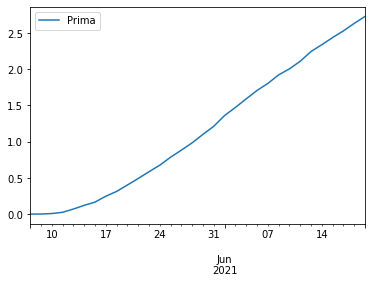

In [42]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()},index=dates)
put.plot();

In [43]:
put.iloc[-1]

Prima    2.728
Name: 2021-06-18 00:00:00, dtype: float64

In [44]:
opcion['JSON']['lastPrice']

2.27

## Intervalos de confianza

In [45]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(2.2215827781646733, 3.2349539265355607)


## Histograma de rendimientos

In [46]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [47]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

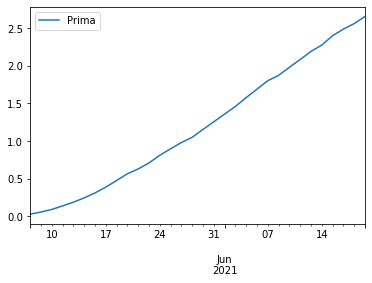

In [48]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [49]:
put_hist.iloc[-1]

Prima    2.657
Name: 2021-06-18 00:00:00, dtype: float64

In [50]:
opcion['JSON']['lastPrice']

2.27

## Intervalos de confianza

In [51]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(2.1584130880027392, 3.154973763072794)


## Valuación de una put como una barrera up and out

> Como es un up la barrera debe estar por encima del spot price

In [52]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 260

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-06,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True
2021-05-11,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True
2021-05-12,True,True,True,True,False,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,False,False,True,True,False,False,False,...,True,True,False,True,False,False,True
2021-06-15,False,False,True,True,False,False,False,...,True,True,False,True,False,False,True
2021-06-16,False,False,True,True,False,False,False,...,True,True,False,True,False,False,True
2021-06-17,False,False,True,True,False,False,False,...,True,True,False,True,False,False,True


## Valuación con rendimientos normales

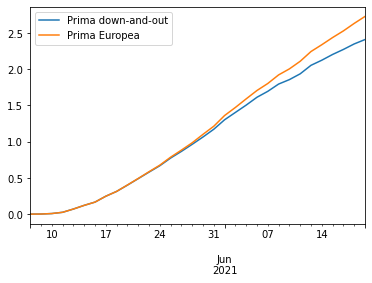

In [53]:
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [54]:
putui.iloc[-1]

Prima down-and-out    2.409
Name: 2021-06-18 00:00:00, dtype: float64

In [55]:
put.iloc[-1]

Prima Europea    2.728
Name: 2021-06-18 00:00:00, dtype: float64

## Valuación con el histograma

In [56]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)

prob = freq/np.sum(freq)

In [57]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opcion.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opcion.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

In [58]:
pd.set_option('display.max_columns',15)

#Defino el precio de la barrera como

B = 260

# Función de desactivación knock out
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes_hist < B).cumprod() > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
2021-05-06,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-07,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-10,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-11,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2021-05-12,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-14,True,True,True,False,True,True,True,...,True,True,True,True,False,False,True
2021-06-15,True,True,True,False,True,True,True,...,True,True,True,True,False,False,True
2021-06-16,True,True,True,False,True,True,True,...,True,True,True,True,False,False,True
2021-06-17,True,True,True,False,True,True,True,...,True,True,True,True,False,False,True


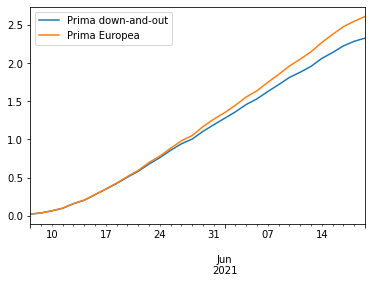

In [59]:
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes_hist, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [60]:
putui.iloc[-1]

Prima down-and-out    2.325
Name: 2021-06-18 00:00:00, dtype: float64

In [61]:
put.iloc[-1]

Prima Europea    2.609
Name: 2021-06-18 00:00:00, dtype: float64

In [62]:
opcion['JSON']['lastPrice']

2.27

## Análisis

Primeramnete podemos observar que el valor de las primas europeas en contraste con el valor real tuvieron cierto nivel de error sobre todo la call la cual tenía un last price de $V = 4.75$. Mientrás que la valuación como call Europea fue de $call = 8.502$ por el método del histogram mientrás que por el método de los rendimientos normales fue de $call = 8.149$ por lo que este último método fue más preciso, sin embargo, el put se aproximo mejor de tener un last price de $V = 2.27$ y la valuación de put Europea fue de $put = 2.608$ por el método del histograma y por el método de los rendimientos normales fue de $put = 2.703$ por lo tanto el método de los rendimientos normales fue más preciso.

En cuanto a la valuación del put up and out se logro obtener una valoración menor a la europea el cual fue de $up/out=2.353$ por el método del histograma y $up/out=2.38$ por el método de rendimientos normales. En este caso se estableció una barrera en 260, mientrás que el spot price es de 249.51 y el strike price de k =230 (utilizando la sonrisa de volatilidad para definirlo). Esto nos podría dar el derecho a vender (siempre y cuando no toquemos la barrera) a $S_t=260$ esperando que el precio del activo pueda bajar ya que desde una perspectiva fundamentalista esta sobrevalorado y ante el riesgo de alsas en la tasa de interés los activos de alto rendimiento como el nuestro podrían sufir una correción a la baja.

Referente a la valuación call down and out se logro obtener una menor valuación $down/out = 7.328$ por el método del historgama y de $down/out = 6.652$ por el método de los rendimientos normales en contraste a la europea. Se estableció una barrera en $S_t=240$, pensando en que nuestro activo pueda continuar apreciandose mientrás las tasas de interés sigan bajas y la tendencia bullish del mercado continue defino un strike price $k =255$ (utilizando la sonrisa de volatilidad para definirlo).

En conclusión las opciones barrera ofrecen una gran alternativa a las europeas ya que salimos beneficiados en cuestión de costos, no obstante, se debe definir muy bien la estrategia a utilizar ya que en donde decidamos ubicar la barrera resultara fundamental para poder ejercer nuestra opción por lo que un estudio detallado del comportamiento del subyacente se debería realizar previamente. 

Finalmente con respecto a los métodos de aproximación me llamo la atención que para las opciones europeas asumir el método de rendimientos normales obtuvo mejores aproximaciones, mientrás que por el otro lado, las aproximaciones de las opciones barreras u _opciones_ exoticas tuvieron mejores aproximaciones con el método del histograma. En el caso de las europeas esto podría deberse a que en el método de rendimientos normales utilizamos la solución a la ecuación de B&S, ecuación que ofrece una solución cerrada para opciones europeas. En el caso de las opciones barrera al ser _exoticas_ y no tener una solución cerrada como B&S se utilizan otros metodos numericos para aproximar su valor como en este caso el del hsitograma.
